## Deep Learning Project: 

A study on reinforcement learning for the game of Super Mario Bros on the NES. 

By: Stricescu Razvan Ciprian

In [1]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os

# Gym is an OpenAI toolkit for RL
import gym
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation
from gym import spaces
# NES Emulator for OpenAI Gym
from nes_py.wrappers import JoypadSpace

# Super Mario environment for OpenAI Gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY, COMPLEX_MOVEMENT

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

import numpy as np
import time, datetime
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Here I define the environment based on the version of gym as the gym_super_mario_bros library is not compatible with the latest version of gym and requires apy compatibility.

The main difference is in the step function which returns **{next state, reward, done, trunc, info}** instead of **{next state, reward, done, trunc, info}**.

The reward function assumes the objective of the game is to move as far right as possible (increase the agent's x value), as fast as possible, without dying.

The reward function is defined as follows:
- v: the difference in agent x values between states.
- c: the difference in the game clock between frames.
- d: a death penalty that penalizes the agent for dying in a state.

Thus the reward function is defined as: **v + c + d**


In [3]:
if gym.__version__ < '0.26':
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", new_step_api=True)
else:
    env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0", apply_api_compatibility=True)

env_name = env.spec.id # will be used to save files later

d:\Anaconda\envs\torch_env_rl\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(


The info returned by the step function is a dictionary containing the following information:

|   coins  |             number of coins             |
|:--------:|:---------------------------------------:|
| flag_get |      whether mario got to the flag      |
|   life   |           number of lifes left          |
|   score  |               total score               |
|   stage  |            level in the world           |
|  status  | mario's status (small, large, fireball) |
|   time   |      time left on the in-game clock     |
|   world  |              current world              |
|   x_pos  |           horizontal position           |
|   y_pos  |            vertical position            |


### Preprocessing:

In order to optimize the training process, the following preprocessing steps were taken as environment wrappers:

- **Skip Frames**: The environment is wrapped in a skip frame wrapper that skips a number of frames and returns the last frame as the state. This is done to reduce the number of frames the agent has to process and to speed up the training process.

- **Gray Scale**: The environment is wrapped in a gray scale wrapper that converts the state to gray scale. This is done to reduce the number of channels the agent has to process and to speed up the training process.

- **Resize**: The environment is wrapped in a resize wrapper that resizes the state to a smaller size. This is done to reduce the number of pixels the agent has to process and to speed up the training process.

In [4]:
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        x_pos = 0
        for i in range(self._skip):
            obs, reward, done, trunc, info = self.env.step(action)
            if info['x_pos'] > x_pos:
                total_reward += reward
                x_pos = info['x_pos']
            else:
                total_reward -= 0.5
                x_pos = info['x_pos']
            if done:
                break
        return obs, total_reward, done, trunc, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)
    
def apply_wrappers(env):
    env = JoypadSpace(env, RIGHT_ONLY)
    env = SkipFrame(env, skip=4)
    env = ResizeObservation(env, shape=84)
    env = GrayScaleObservation(env)
    env = FrameStack(env, num_stack=4, lz4_compress=True)
    return env

In [5]:
class AgentNN(nn.Module):
    def __init__(self, input_shape, n_actions, freeze=False):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)

        self.net = nn.Sequential(
            self.conv_layers,
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        if freeze:
            self._freeze()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)


    def _get_conv_out(self, shape):
        o = self.conv_layers(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def _freeze(self):
        for param in self.net.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.net(x)

In [6]:
class Agent:
    def __init__(self, input_dims, num_actions, load=False):
        self.num_actions = num_actions
        self.learn_step_counter = 0

        # Hyperparams
        self.lr = 0.00025
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.99999975
        self.batch_size = 32
        self.sync_net_rate = 10000

        # Nets
        self.q_net = AgentNN(input_dims, num_actions)
        self.target_net = AgentNN(input_dims, num_actions, freeze=True)

        # Optimizer 
        self.optimizer = torch.optim.Adam(self.q_net.parameters(), lr=self.lr)

        # Loss
        self.loss = nn.MSELoss() # Tried Huber loss, but it didn't work well
        storage = LazyMemmapStorage(100000, scratch_dir=os.path.join(os.getcwd(), 'scratch'))

        # Replay buffer
        if load: #TODO: Wait for torchrl to release new version that supports loading and dumping
            self.replay_buffer = TensorDictReplayBuffer(storage=storage)
            self.replay_buffer._storage = TensorDict.load_memmap(os.path.join(os.getcwd(), 'scratch'))
        else:
            self.replay_buffer = TensorDictReplayBuffer(storage=storage)


    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.num_actions)
        state = torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0).to(self.q_net.device)
        return self.q_net(state).argmax().item()
    

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)

    
    def store_transition(self, state, action, reward, next_state, done):
        self.replay_buffer.add(TensorDict({
            'state': torch.tensor(np.array(state), dtype=torch.float32),
            'action': torch.tensor(action),
            'reward': torch.tensor(reward),
            'next_state': torch.tensor(np.array(next_state), dtype=torch.float32),
            'done': torch.tensor(done)
        }, batch_size=[]))

    
    def sync_nets(self):
        if self.learn_step_counter % self.sync_net_rate == 0 and self.learn_step_counter > 0:
            self.target_net.load_state_dict(self.q_net.state_dict())


    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return (0, 0)

        self.sync_nets()

        self.optimizer.zero_grad()
        samples = self.replay_buffer.sample(self.batch_size).to(self.q_net.device)

        keys = ['state', 'action', 'reward', 'next_state', 'done']

        states, actions, rewards, next_states, dones = [samples[k] for k in keys]

        predicted_q_values = self.q_net(states)
        predicted_q_values = predicted_q_values[np.arange(self.batch_size), actions.squeeze()]

        target_q_values = self.target_net(next_states).max(dim=1)[0]
        target_q_values = rewards + self.gamma*target_q_values*(1-dones.float())

        loss = self.loss(predicted_q_values, target_q_values)
        loss.backward()
        self.optimizer.step()

        self.learn_step_counter += 1
        self.decay_epsilon()
        return (predicted_q_values.mean().item(), loss.item())

    
    def save_model(self, path):
        torch.save(self.q_net.state_dict(), path)
        #self.replay_buffer.dumps(os.path.join(os.getcwd(), 'scratch')) #TODO: Wait for torchrl to release new version that supports loading and dumping


    def load_model(self, path):
        self.q_net.load_state_dict(torch.load(path))
        self.target_net.load_state_dict(torch.load(path))
        #self.replay_buffer._storage = TensorDict.load_memmap(os.path.join(os.getcwd(), 'scratch')) #TODO: Wait for torchrl to release new version that supports loading and dumping


In [7]:
class MetricLogger:
    def __init__(self, save_dir):
        self.save_log = save_dir / "log"
        with open(self.save_log, "w") as f:
            f.write(
                f"{'Episode':>8}{'Step':>8}{'Epsilon':>10}{'MeanReward':>15}"
                f"{'MeanLength':>15}{'MeanLoss':>15}{'MeanQValue':>15}"
                f"{'TimeDelta':>15}{'Time':>20}\n"
            )
        self.ep_rewards_plot = save_dir / "reward_plot.jpg"
        self.ep_lengths_plot = save_dir / "length_plot.jpg"
        self.ep_avg_losses_plot = save_dir / "loss_plot.jpg"
        self.ep_avg_qs_plot = save_dir / "q_plot.jpg"

        # History metrics
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_avg_losses = []
        self.ep_avg_qs = []

        # Moving averages, added for every call to record()
        self.moving_avg_ep_rewards = []
        self.moving_avg_ep_lengths = []
        self.moving_avg_ep_avg_losses = []
        self.moving_avg_ep_avg_qs = []

        # Current episode metric
        self.init_episode()

        # Timing
        self.record_time = time.time()

    def log_step(self, reward, loss, q):
        # Update metrics of current episode
        self.curr_ep_reward += reward
        self.curr_ep_length += 1
        if loss:
            self.curr_ep_loss += loss
            self.curr_ep_q += q
            self.curr_ep_loss_length += 1

    def log_episode(self):
        "Mark end of episode"
        self.ep_rewards.append(self.curr_ep_reward)
        self.ep_lengths.append(self.curr_ep_length)
        if self.curr_ep_loss_length == 0:
            ep_avg_loss = 0
            ep_avg_q = 0
        else:
            ep_avg_loss = np.round(self.curr_ep_loss / self.curr_ep_loss_length, 5)
            ep_avg_q = np.round(self.curr_ep_q / self.curr_ep_loss_length, 5)
        self.ep_avg_losses.append(ep_avg_loss)
        self.ep_avg_qs.append(ep_avg_q)

        self.init_episode()

    def init_episode(self):
        "Reset episode metrics"
        self.curr_ep_reward = 0.0
        self.curr_ep_length = 0
        self.curr_ep_loss = 0.0
        self.curr_ep_q = 0.0
        self.curr_ep_loss_length = 0

    def record(self, episode, epsilon, step):
        # Save metrics from current episode to history
        mean_ep_reward = np.round(np.mean(self.ep_rewards[-100:]), 3)
        mean_ep_length = np.round(np.mean(self.ep_lengths[-100:]), 3)
        mean_ep_loss = np.round(np.mean(self.ep_avg_losses[-100:]), 3)
        mean_ep_q = np.round(np.mean(self.ep_avg_qs[-100:]), 3)
        self.moving_avg_ep_rewards.append(mean_ep_reward)
        self.moving_avg_ep_lengths.append(mean_ep_length)
        self.moving_avg_ep_avg_losses.append(mean_ep_loss)
        self.moving_avg_ep_avg_qs.append(mean_ep_q)

        last_record_time = self.record_time
        self.record_time = time.time()
        time_since_last_record = np.round(self.record_time - last_record_time, 3)

        '''
        print(
            f"Episode {episode} - "
            f"Step {step} - "
            f"Epsilon {epsilon} - "
            f"Mean Reward {mean_ep_reward} - "
            f"Mean Length {mean_ep_length} - "
            f"Mean Loss {mean_ep_loss} - "
            f"Mean Q Value {mean_ep_q} - "
            f"Time Delta {time_since_last_record} - "
            f"Time {datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S')}"
        )
        '''
        
        # Save metrics
        with open(self.save_log, "a") as f:
            f.write(
                f"{episode:8d}{step:8d}{epsilon:10.3f}"
                f"{mean_ep_reward:15.3f}{mean_ep_length:15.3f}{mean_ep_loss:15.3f}{mean_ep_q:15.3f}"
                f"{time_since_last_record:15.3f}"
                f"{datetime.datetime.now().strftime('%Y-%m-%dT%H:%M:%S'):>20}\n"
            )

        # Plot metrics
        for metric in ["ep_lengths", "ep_avg_losses", "ep_avg_qs", "ep_rewards"]:
            plt.clf()
            plt.plot(getattr(self, f"moving_avg_{metric}"), label=f"moving_avg_{metric}")
            plt.legend()
            plt.savefig(getattr(self, f"{metric}_plot"))

d:\Anaconda\envs\torch_env_rl\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 0 - Step 0 - Epsilon 1.0 - Mean Reward 248.5 - Mean Length 29.0 - Mean Loss 0.0 - Mean Q Value 0.0 - Time Delta 0.35 - Time 2024-01-27T11:53:40
cuda |Episode : 10 | score : 336.650000 | epsilon : 0.9996 | buffer size : 1497 | learn step counter : 1466
Episode 9 - Step 1466 - Epsilon 0.9996335671070734 - Mean Reward 336.65 - Mean Length 149.7 - Mean Loss 6.888 - Mean Q Value 5.917 - Time Delta 28.181 - Time 2024-01-27T11:54:08


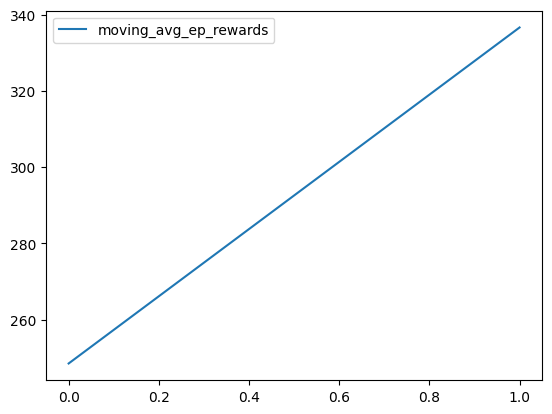

In [8]:
env = apply_wrappers(env)
NUM_EPISODES = 10 
update_interval = 10
CKPT_SAVE_INTERVAL = 10
SHOULD_TRAIN = True
SHOULD_LOAD_FROM_CKPT = False
STARTING_EP = 0

# Creating directories to save models and log files
save_dir = Path("checkpoints") / datetime.datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
save_dir.mkdir(parents=True)

agent = Agent(input_dims=env.observation_space.shape, num_actions=env.action_space.n, load=SHOULD_LOAD_FROM_CKPT)
if not SHOULD_TRAIN:
    ckpt_name = "{env_name}_q.pth" # CHANGE THIS TO THE NAME OF THE CHECKPOINT YOU WANT TO LOAD FROM
    agent.load_model(ckpt_name)
    agent.epsilon = 0.2
    agent.eps_min = 0.0
    agent.eps_decay = 0.0

#TODO: Wait for torchrl to release new version that supports loading and dumping
if SHOULD_LOAD_FROM_CKPT:
    ckpt_name = "checkpoints\\2024-01-26T17-14-56\\model_SuperMarioBros-1-1-v0_20_iter.pt"
    agent.load_model(ckpt_name)
    agent.epsilon = 0.9985
    STARTING_EP = 20
    NUM_EPISODES = NUM_EPISODES + STARTING_EP


env.reset()
next_state, reward, done, trunc, info = env.step(action=0)
total_score = 0.0
# open a log file
log_file = open(os.path.join(save_dir, "log_backup.txt"), "w")
logger = MetricLogger(save_dir)

for i in range(STARTING_EP, NUM_EPISODES):
    done = False
    state, _ = env.reset()
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _, info = env.step(action)
        total_score += reward
        if SHOULD_TRAIN:
            agent.store_transition(state, action, reward, next_state, done)
            q, loss = agent.learn()
            logger.log_step(reward, loss, q)
        state = next_state
        #env.render()
    
    if (i+1) % update_interval == 0 and i > 0:
        print(
                "%s |Episode : %d | score : %f | epsilon : %.4f | buffer size : %d | learn step counter : %d" 
                % (
                    "cuda" if torch.cuda.is_available() else "cpu",
                    i+1,
                    total_score /update_interval, 
                    agent.epsilon,
                    len(agent.replay_buffer),
                    agent.learn_step_counter
                )
            )
        log_file.write(
                "%s |Episode : %d | score : %f | epsilon : %.4f | buffer size : %d | learn step counter : %d\n" 
                % (
                    "cuda" if torch.cuda.is_available() else "cpu",
                    i,
                    total_score /update_interval, 
                    agent.epsilon,
                    len(agent.replay_buffer),
                    agent.learn_step_counter
                    # write log file
                )
            )
        total_score = 0.0
    
    if SHOULD_TRAIN and (i + 1) % CKPT_SAVE_INTERVAL == 0:
        agent.save_model(os.path.join(save_dir, "model_"+env_name+"_" + str(i + 1) + "_iter.pt"))
    
    logger.log_episode()
    if (i % update_interval) == 0 or (i == NUM_EPISODES - 1):
        logger.record(i, agent.epsilon, agent.learn_step_counter)
log_file.close()